In [26]:
import numpy as np

from ffnavpy.analysis import run_analysis
from ffnavpy.plotting import save_plots, plot_results, plot_position
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation configuration

In [27]:
# Initial state of deputy [km, km/s]

x0 = np.array(
    [
        1.5097937630e11,
        -4.6840029080e-08,
        1.8369701987e-08,
        -6.0196990433e-15,
        1.5667113355e02,
        -1.1858897424e02,
    ]
)  # [m / m/s], 'P1-IdealSynodic', Sun-Earth
x0 = np.array([ 1.51221927e+11,
                1.46847862e+07,
                3.13475840e+08,
               -1.76215637e+01,
               -1.53877076e+02,
               -1.02571790e+00])

# Initial relative state [km, km/s]
dx0 = np.array([100, 100, 100, 0, 0, 0])



# State commanded
x_target = np.array([-500, -500, -500, 0, 0, 0])

# Duration of the simulation [s]
tf = 3600 * 12

# Time step of simulation [s]
dT = 100

configOBC = {'x_target': x_target, 
             'estimation_mode': 'kalman',
             'control_mode': 'ETM',
             'Tsk': 100,
             'sigma_r0': 1e-6,
             'sigma_v0': 1e-6,
             'sigma_x': 1e-4,
             'sigma_y': 1e-4,
             'sigma_z': 1e-4,
             'period': 3600,
             'horizon': 10,
             'u_threshold_v': np.ones(3) * 0.015,
             'x_threshold': np.concatenate([0.2*np.ones(3),0.0001*np.ones(3)]),
             'thrust_nominal' : 1e-3,
             'tb_min' : 0.01,
             'tb_lower_limit': 0.008,
             'X0' : dx0,
             'Rkoz' : 50
             }

configSim = {'sigma_distance': 1e-04, 'sigma_angle': 0.25}

# cmd_sequence = CommandSequence()
# configOBC_A = configOBC.copy()

# configOBC_A['u_threshold_v'] = np.ones(3) * 0.00015

# cmd_sequence.add_command('update_configOBC', configOBC_A, 1000)
# cmd_sequence.add_command('change_control_mode', 'simple', 1000)
# cmd_sequence.add_command('change_estimation_mode', 'kalman', 3000)
# cmd_sequence.add_command('change_control_mode', 'LQR', 4800)
# cmd_sequence.add_command('change_control_mode', 'ETM', 3600*2)

# Create predefined case for chief-deputy formation
# simcase = ChiefDeputyCase(LiteBird, CalSat, cmd_sequence=cmd_sequence, configOBC=ConfigOBC)



### ETM analysis

In [28]:
sim_etm = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim)

100%|██████████| 433/433 [00:06<00:00, 69.35it/s]


### MPC analysis

In [29]:
configOBC['control_mode'] = 'MPC'

configOBC['period'] = 15*60

In [30]:
sim_mpc = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim)

100%|██████████| 433/433 [00:07<00:00, 61.27it/s]


In [31]:
configOBC['collision_avoidance'] = True

In [32]:
sim_mpc_ca = run_analysis(x0, dx0, x_target, tf, dT, configOBC, configSim)

100%|██████████| 433/433 [00:07<00:00, 60.08it/s]


In [33]:
xdstyle = {
        "color": "b",
        "linestyle": "-",
        "linewidth": 1.2,
        # "marker": "+",
        "markersize": 4,
    }

fontdict = {'family': 'serif',
        'weight': 'normal',
        'size': 12,
        }

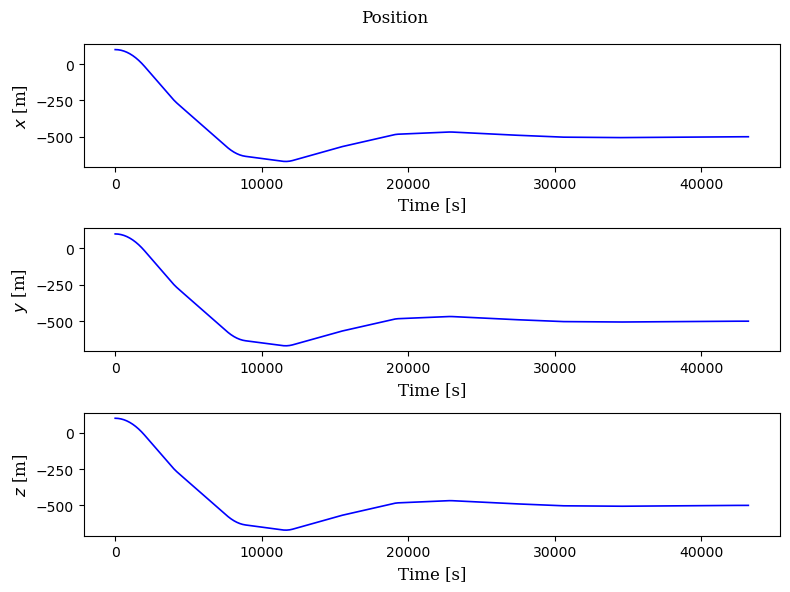

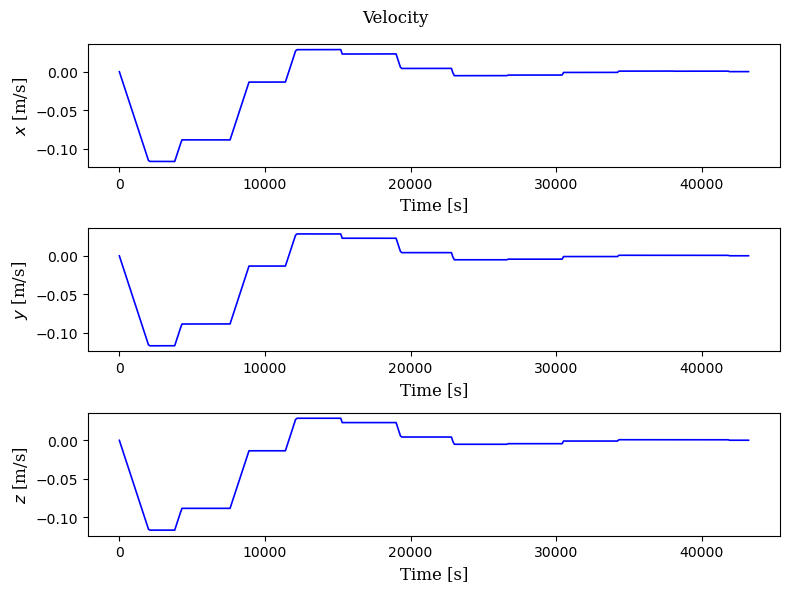

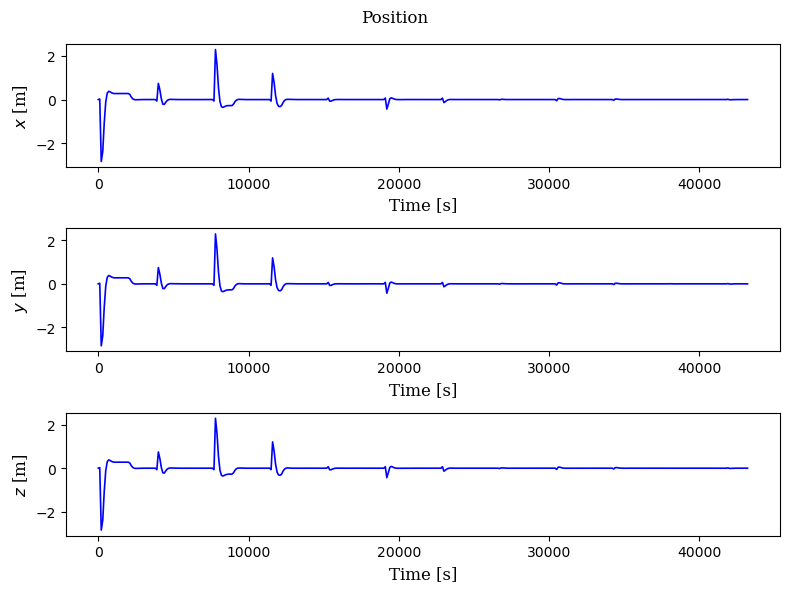

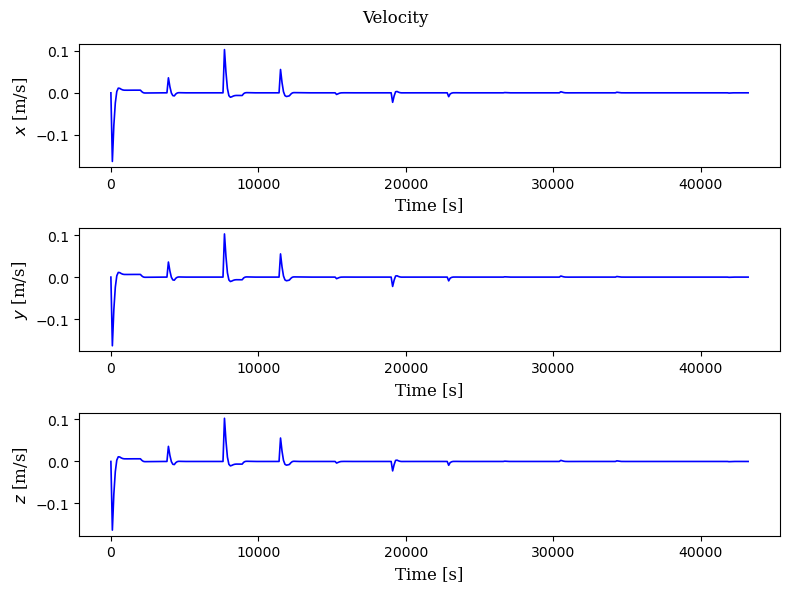

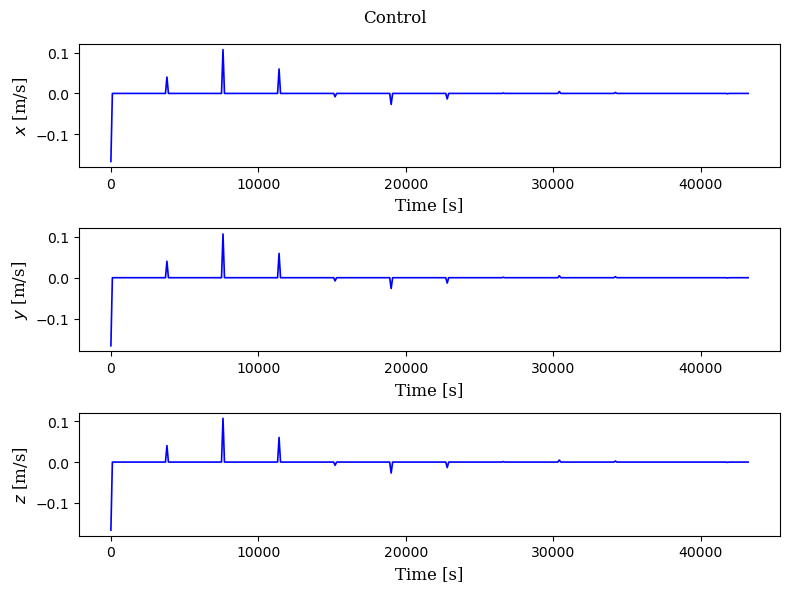

In [34]:
fig_dict_etm = plot_results(sim_etm, xdstyle, fontdict)
save_plots(fig_dict_etm, "reconfiguration_etm", "reconfiguration")

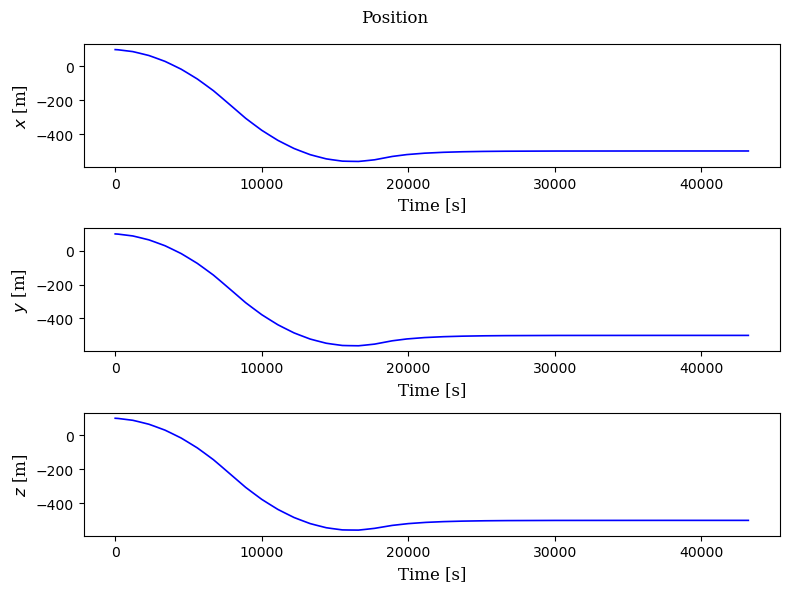

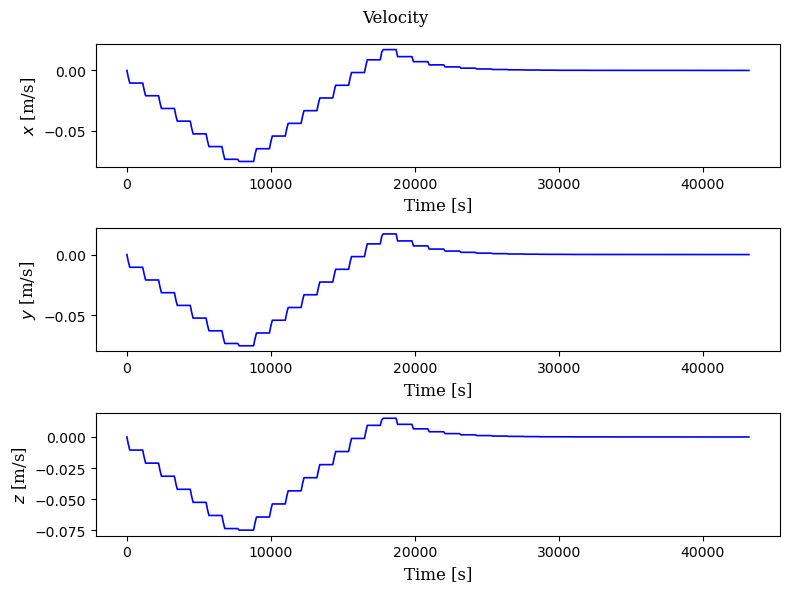

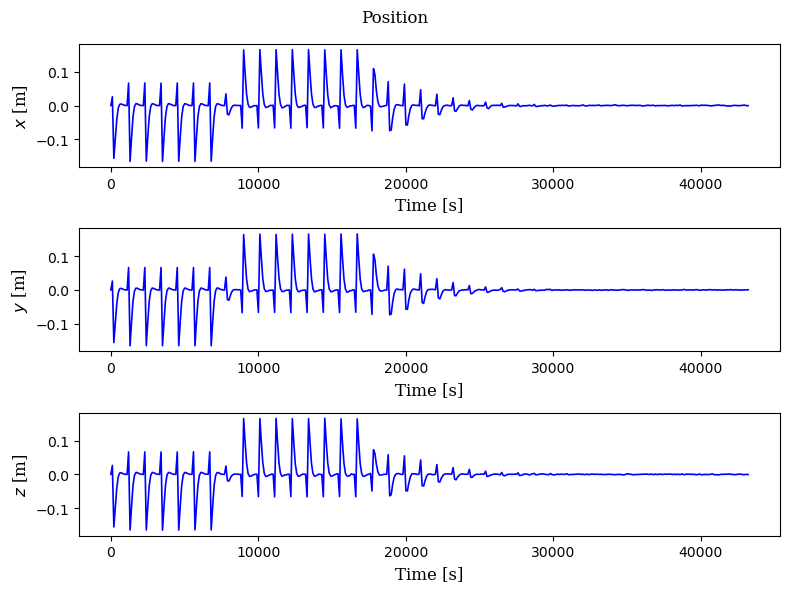

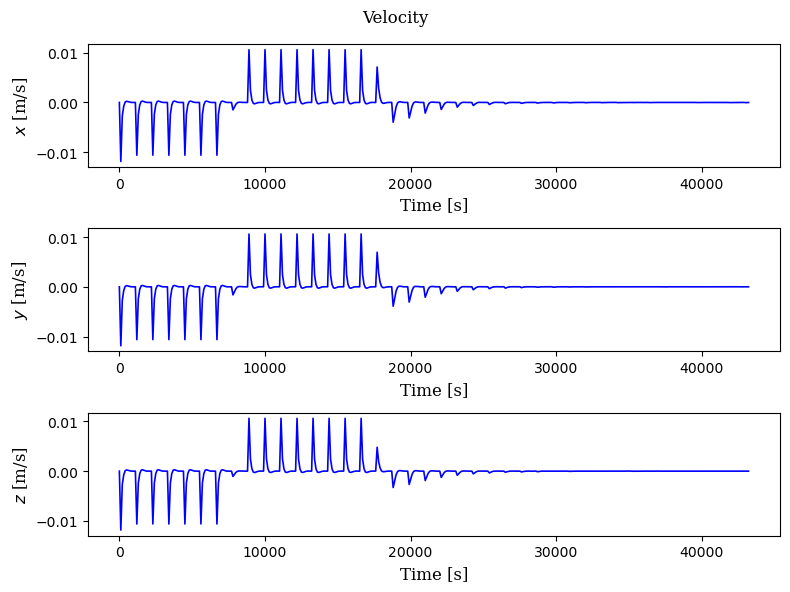

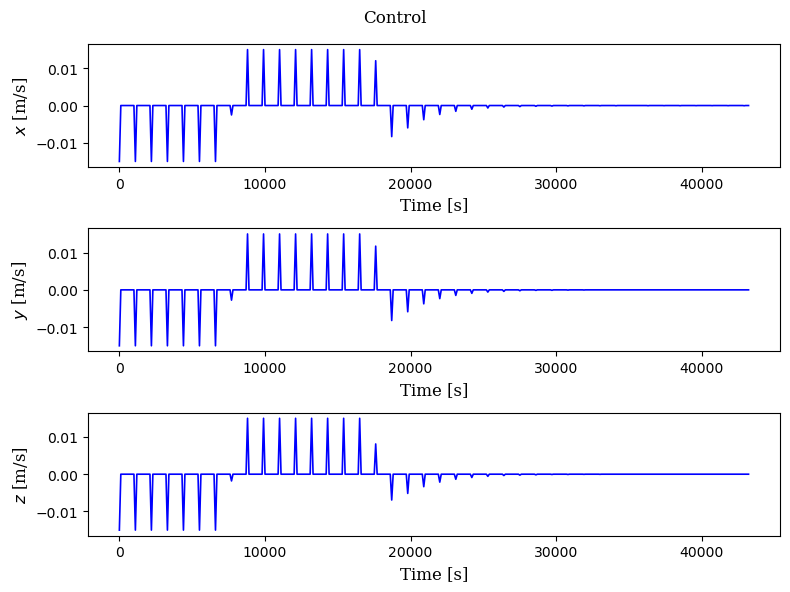

In [35]:
fig_dict_mpc = plot_results(sim_mpc, xdstyle, fontdict)
save_plots(fig_dict_mpc, "reconfiguration_mpc", "reconfiguration")

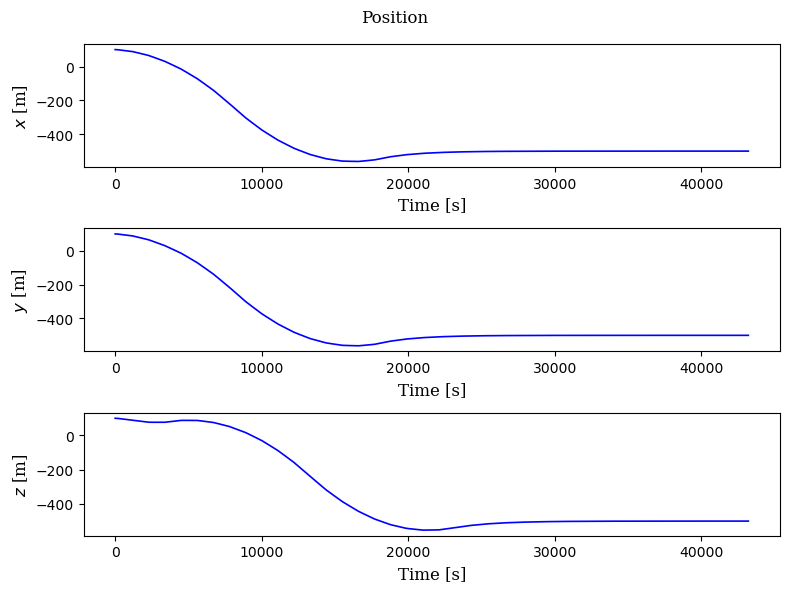

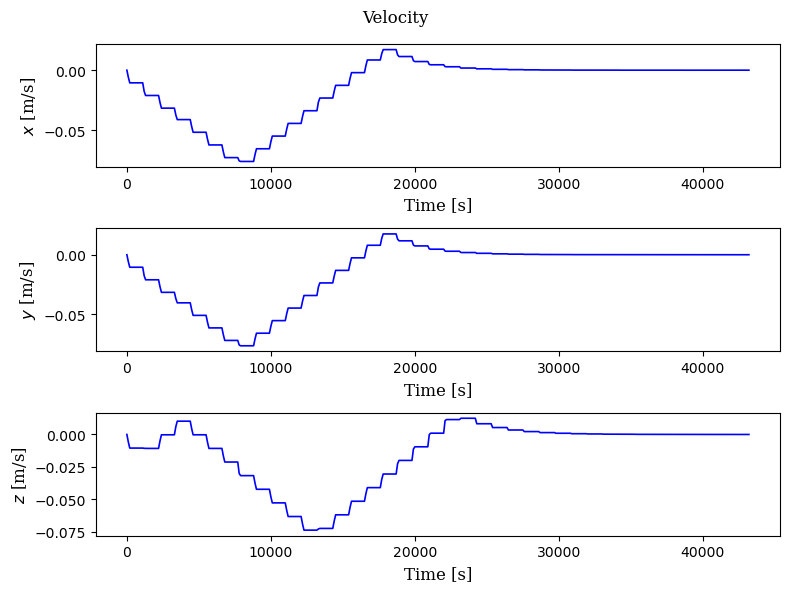

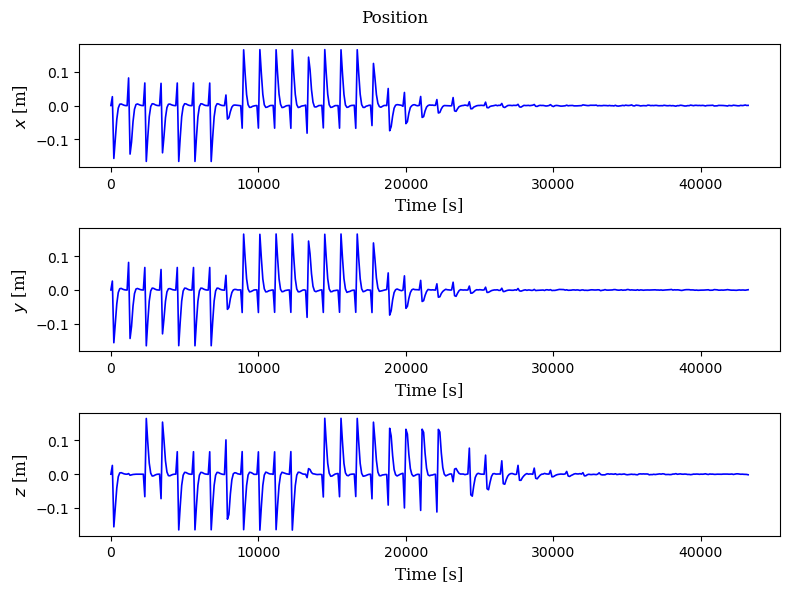

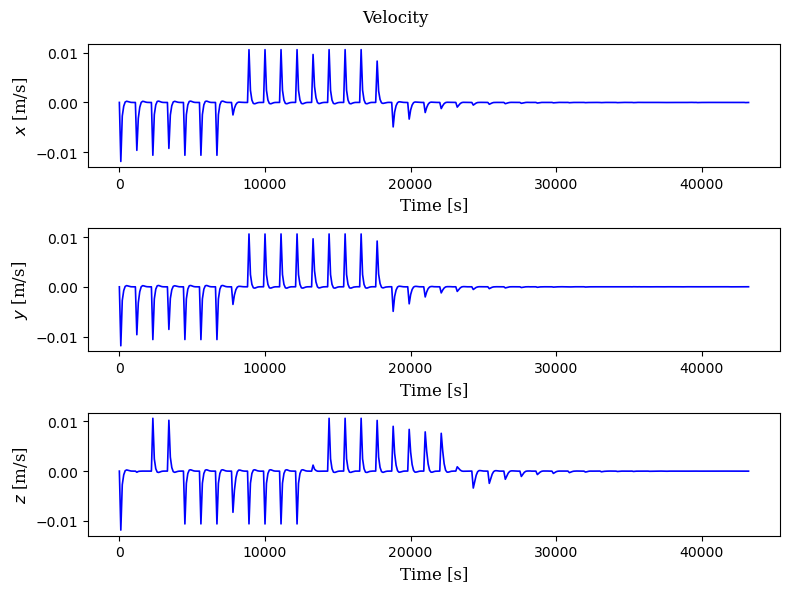

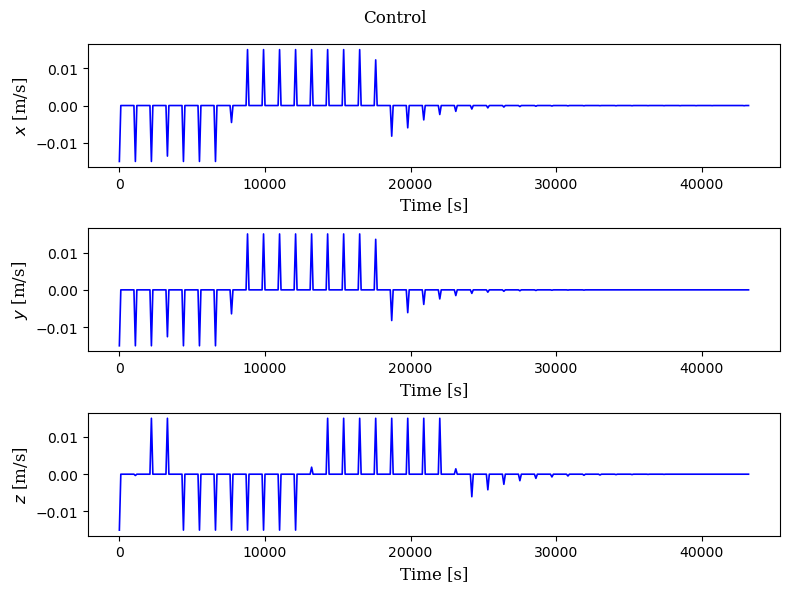

In [36]:
fig_dict_mpc_ca = plot_results(sim_mpc_ca, xdstyle, fontdict)
save_plots(fig_dict_mpc_ca, "reconfiguration_mpc_ca", "reconfiguration")

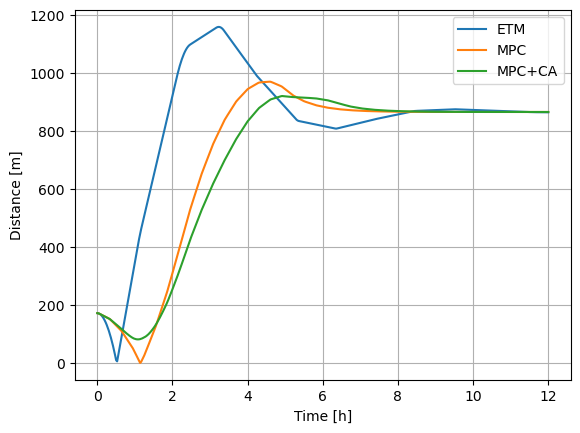

In [37]:
plt.figure()
plt.plot(sim_etm.report.time/3600, np.linalg.norm(sim_etm.report.relative_state[:3,:], axis=0))
plt.plot(sim_mpc.report.time/3600, np.linalg.norm(sim_mpc.report.relative_state[:3,:], axis=0))
plt.plot(sim_mpc_ca.report.time/3600, np.linalg.norm(sim_mpc_ca.report.relative_state[:3,:], axis=0))
plt.legend(['ETM', 'MPC', 'MPC+CA'])
plt.grid()
plt.xlabel('Time [h]')
plt.ylabel('Distance [m]')
plt.savefig('reconfiguration_final/distance_reconfiguration.pdf', format='pdf', dpi=300)

In [38]:
sim_etm.report.DV

1.295138429219151

In [39]:
sim_mpc.report.DV

0.7851735721193027

In [40]:
sim_mpc_ca.report.DV

0.8395645409283876

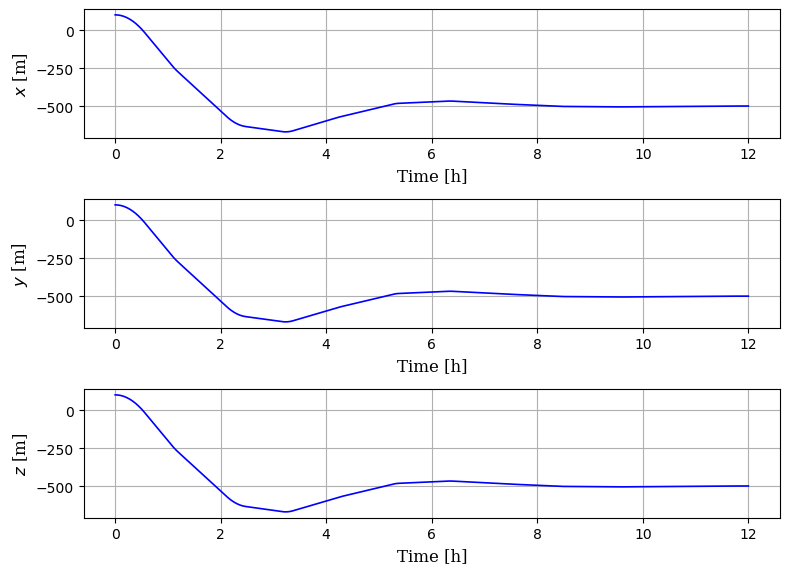

In [41]:
fig, ax = plot_position(sim_etm.report.time/3600, sim_etm.report.relative_state[:3,:], xdstyle=xdstyle, fontdict=fontdict, units=("h", "m"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'position':(fig, ax)}, "reconfiguration_etm", "reconfiguration_final")

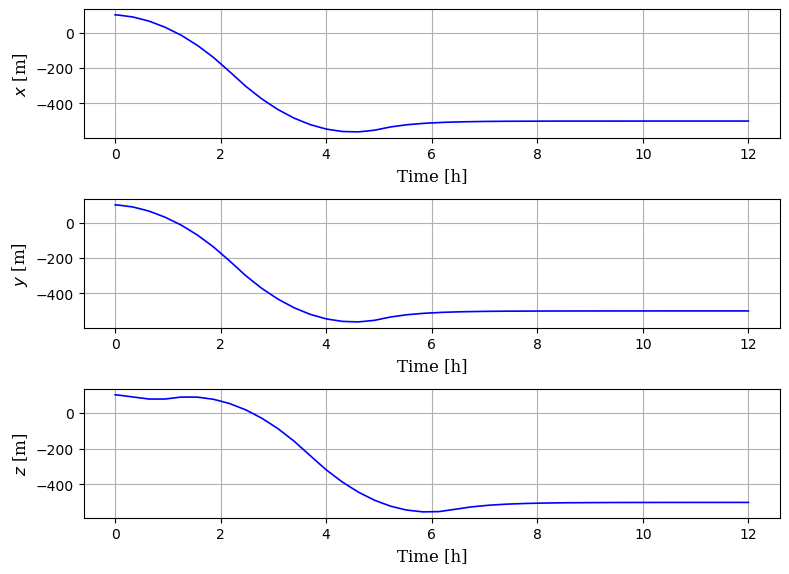

In [42]:
fig, ax = plot_position(sim_mpc_ca.report.time/3600, sim_mpc_ca.report.relative_state[:3,:], xdstyle=xdstyle, fontdict=fontdict, units=("h", "m"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'position':(fig, ax)}, "reconfiguration_mpc", "reconfiguration_final")

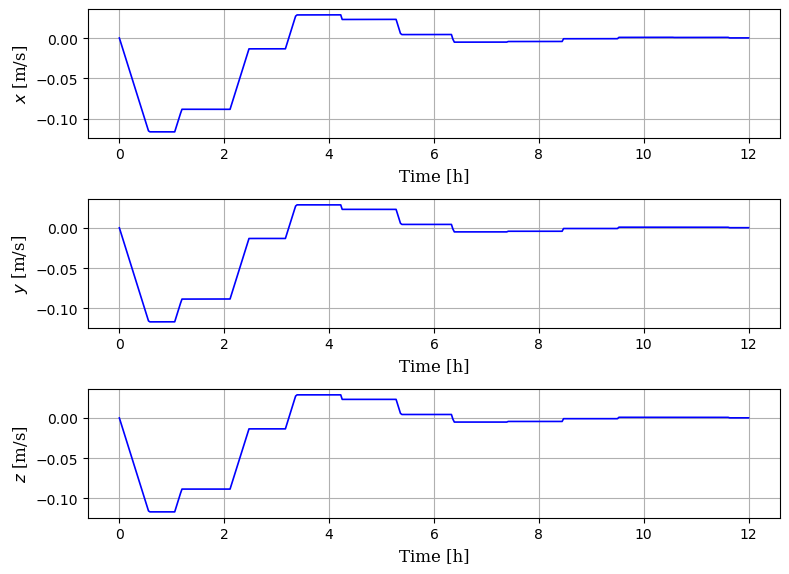

In [43]:
fig, ax = plot_position(sim_etm.report.time/3600, sim_etm.report.relative_state[3:,:], xdstyle=xdstyle, fontdict=fontdict, units=("h", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'velocity':(fig, ax)}, "reconfiguration_etm", "reconfiguration_final")

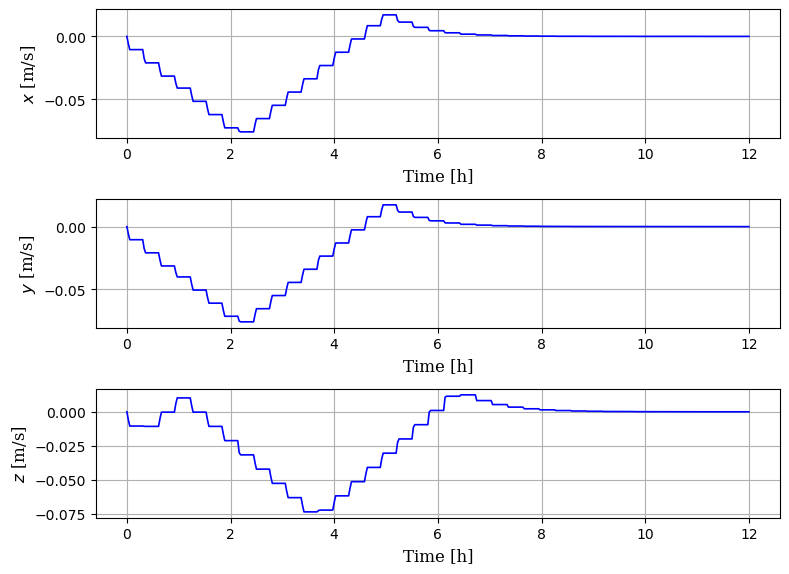

In [44]:
fig, ax = plot_position(sim_mpc_ca.report.time/3600, sim_mpc_ca.report.relative_state[3:, :], xdstyle=xdstyle, fontdict=fontdict, units=("h", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'velocity':(fig, ax)}, "reconfiguration_mpc", "reconfiguration_final")

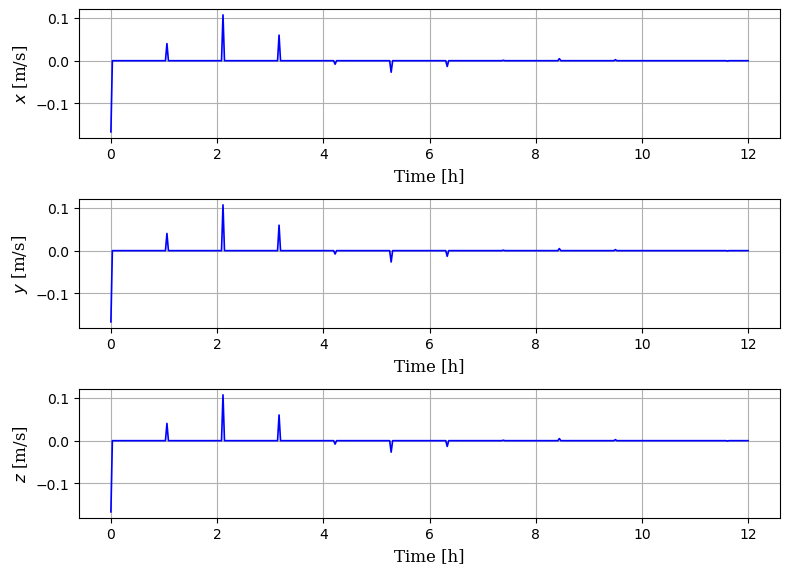

In [45]:
fig, ax = plot_position(sim_etm.report.time/3600, sim_etm.report.u_cmd, xdstyle=xdstyle, fontdict=fontdict, units=("h", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'control':(fig, ax)}, "reconfiguration_etm", "reconfiguration_final")

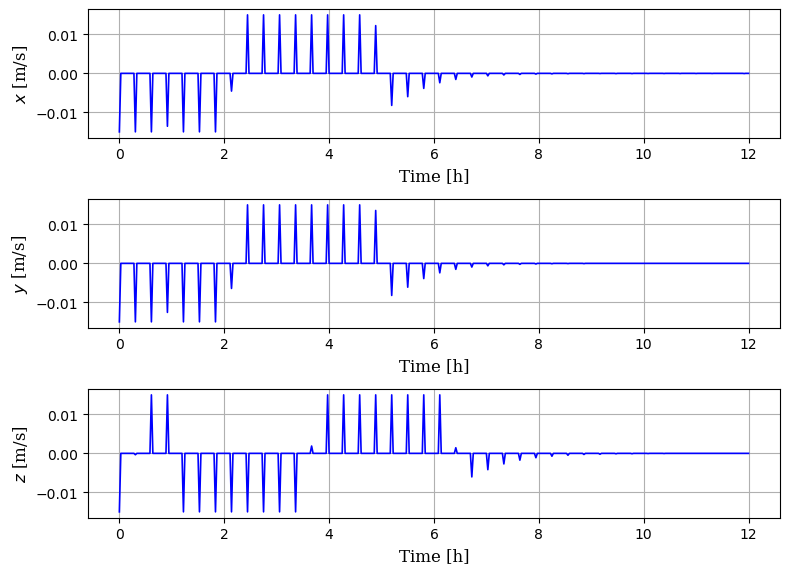

In [46]:
fig, ax = plot_position(sim_mpc_ca.report.time/3600, sim_mpc_ca.report.u_cmd, xdstyle=xdstyle, fontdict=fontdict, units=("h", "m/s"))
fig.suptitle('')
fig.tight_layout()


for axis in ax:
    axis.grid()
#     axis.hlines([99.9, 100.1], sim_lqr.report.time[0]/60, sim_lqr.report.time[-1]/60, colors='k', linestyle='--', linewidth=1)

save_plots({'control':(fig, ax)}, "reconfiguration_mpc", "reconfiguration_final")

In [47]:
0.001/(6*3600)

4.6296296296296295e-08

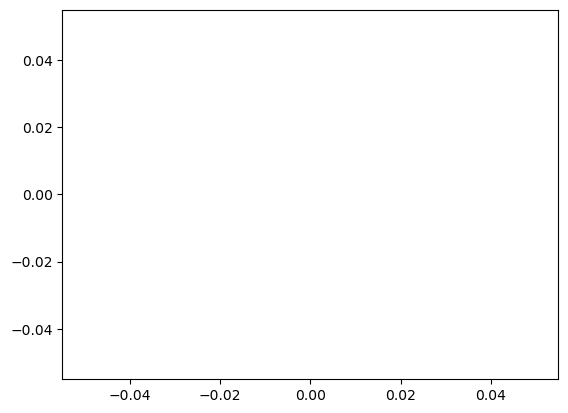

In [48]:
plt.plot(sim_etm.report.relative_state[:3,1200:].T)

In [49]:
9e-6*0.15/7*((60*30)**2/2)

0.3124285714285714

In [50]:
1e-6*3600

0.0036